In [38]:
import csv
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import flatten
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Function to load data
def load_data(csv_file, image_dir):
    X = []
    Y = []
    with open(csv_file, mode="r") as file:
        reader = csv.reader(file)
        next(reader)  # Skip header row
        for row in reader:
            integer1, integer2, image_filename = int(row[0]), int(row[1]), row[2]
            X.append([integer1, integer2])
            img_csv = os.path.join(image_dir, f"{image_filename}.csv")
            with open(img_csv, mode="r") as file2:
                img_reader = csv.reader(file2)
                img_data = []
                for img_row in img_reader:
                    img_data.append([int(pixel) for pixel in img_row])
                img_array = np.array(img_data)
                # Ensure images are 3D arrays (add channel dimension if needed)
                if img_array.ndim == 2:
                    img_array = np.expand_dims(img_array, axis=-1)
                Y.append(img_array)

    X = np.array(X)
    Y = np.array(Y)
    return X, Y


# Define the encoder model
def create_encoder(input_dim, latent_dim):
    encoder_input = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation="relu")(encoder_input)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(512, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    encoder = models.Model(encoder_input, [z_mean, z_log_var], name="encoder")
    return encoder


# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


# Define the decoder model with binary output
def create_decoder(latent_dim, image_shape):
    decoder_input = layers.Input(shape=(latent_dim,))
    x = layers.Dense(512, activation="relu")(decoder_input)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(
        image_shape[0] * image_shape[1] * image_shape[2], activation="sigmoid"
    )(x)
    decoder_output = layers.Reshape(image_shape)(x)
    decoder = models.Model(decoder_input, decoder_output, name="decoder")
    return decoder


# Custom VAE model class
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(kl_loss)
        return reconstructed


# Combine encoder and decoder into VAE model
input_dim = 2  # Two integers as input
latent_dim = 20  # Size of the latent space
image_shape = (322, 322, 1)  # Example image shape (64x64 pixels, 1 channel for binary)

encoder = create_encoder(input_dim, latent_dim)
decoder = create_decoder(latent_dim, image_shape)
vae = VAE(encoder, decoder)
vae.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=binary_crossentropy
)

# Directory where images are saved
image_dir = "output"
# File where integer pairs are saved
csv_file = "input.csv"


# Load real data
X_train, Y_train = load_data(csv_file, image_dir)

# Split data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.5, random_state=42
)

# Train the model
history = vae.fit(
    X_train, Y_train, epochs=50, validation_data=(X_val, Y_val), batch_size=32
)

# # Evaluate the model
# X_test, Y_test = load_data(
#     "input.csv", "output"
# )  # Assuming you have separate test data

test_loss = vae.evaluate(X_val, Y_val)
print(f"Test loss: {test_loss}")


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step - loss: 229.6224 - val_loss: 19.4240
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - loss: 19.6278 - val_loss: 21.1964
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - loss: 19.5763 - val_loss: 16.2973
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - loss: 16.1418 - val_loss: 17.1512
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - loss: 15.7128 - val_loss: 15.2046
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - loss: 14.3939 - val_loss: 15.0686
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - loss: 14.5338 - val_loss: 13.9014
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - loss: 13.4254 - val_loss: 13.3117
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - loss: 13.3763 - val_loss: 12.3611
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - loss: 11.6100 - val_loss: 11.3686
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - loss: 11.4328 - val_loss: 10.2281
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


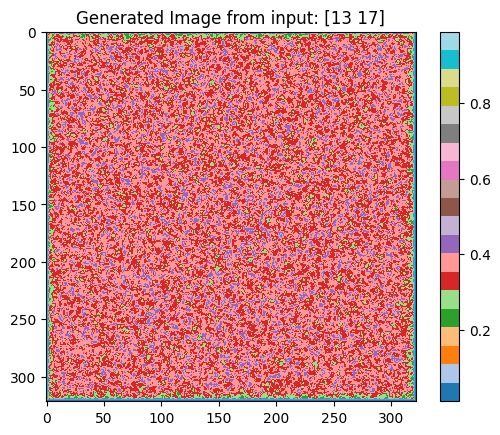

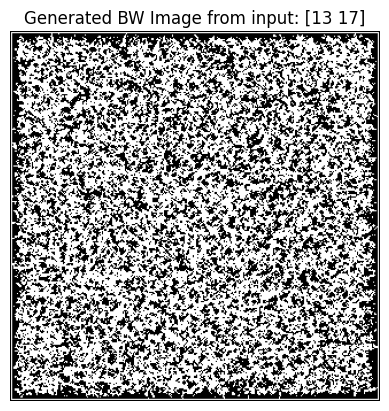

In [39]:
import numpy as np
import matplotlib.pyplot as plt


# Function to generate an image from input integers
def generate_image(vae, integer_pair):
    integer_pair = np.array(integer_pair).reshape(1, -1)
    z_mean, z_log_var = vae.encoder.predict(integer_pair)
    z = sampling([z_mean, z_log_var])
    generated_image = vae.decoder.predict(z)
    generated_image = generated_image.squeeze()  # Remove single-dimensional entries
    return generated_image


# Example integer pair input
integer_pair = X_val[3]

# Generate an image
generated_image = generate_image(vae, integer_pair)

# generated_image = Y_val[3]

# print(generated_image)

# Display the generated image
plt.imshow(generated_image, cmap="tab20")
plt.title(f"Generated Image from input: {integer_pair}")
plt.colorbar()
# plt.axis('off')
plt.show()

threshold = 0.35
binary_image = (generated_image > threshold).astype(np.uint8)

# Display the generated binary image
plt.imshow(binary_image, cmap="gray")
plt.title(f"Generated BW Image from input: {integer_pair}")
plt.axis("off")
plt.show()